In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from PIL import Image

### Prepare the dataset

Download dataset from [Kaggle](https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset/version/1)
to DATA_DIR

In [2]:
DATA_DIR = 'data/myntradataset'
RANDOM_SEED=42

In [3]:
print('DATA_DIR contents:', os.listdir(DATA_DIR))

DATA_DIR contents: ['test.p', 'styles.csv', 'all_data.p', 'images', 'train_top20.p', 'train_other.p', 'class_labels.p']


In [4]:
# Drop invalid entries

In [5]:
def read_and_clean_data(data_dir: str = DATA_DIR):
    df = pd.read_csv(os.path.join(data_dir, 'styles.csv'), error_bad_lines=False)
    # drop entries without an image
    image_files = os.listdir(os.path.join(data_dir, 'images'))
    image_names = df.apply(lambda row: str(row['id']) + '.jpg', axis=1)
    df = df[image_names.isin(image_files)]
    
    # add image path field
    df['image'] = df.apply(lambda row: os.path.join(DATA_DIR, 'images', str(row['id']) + '.jpg'), axis=1)
    df = df.reset_index(drop=True)

    return df

In [6]:
df = read_and_clean_data()
print(f'Clean data shape: {df.shape}')

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

Clean data shape: (44419, 11)


<AxesSubplot:>

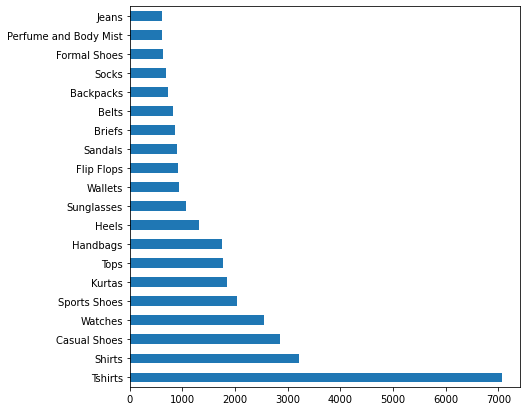

In [7]:
plt.figure(figsize=(7,7))
df.articleType.value_counts().head(20).plot(kind='barh')

In [8]:
print(f'Unique articleTypes in clean dataset: {len(df.articleType.unique())}')

Unique articleTypes in clean dataset: 142


In [9]:
# create integer classes. The order is determined by frequency of each class

In [10]:
def add_classes_to_data(data: pd.DataFrame):
    # create classes from articleType feature
    class_counts = data.articleType.value_counts()
    label_classes = dict((y, x) for (x, y) in enumerate(class_counts.index))
    data['class'] = data.apply(lambda row: label_classes[row['articleType']], axis=1)
    assert data['class'].max() == len(df.articleType.unique()) - 1
    
    # create series with labels to class map
    class_labels = pd.Series(class_counts.index)
    return data, class_labels

In [11]:
df, class_labels = add_classes_to_data(df)
print(f'Dataset with classes shape: {df.shape}')

Dataset with classes shape: (44419, 12)


In [12]:
# save class labels
class_labels.to_pickle(os.path.join(DATA_DIR, 'class_labels.p'))

In [13]:
# Test the size of the images
def find_image_params(data: pd.DataFrame):
    image_params = pd.DataFrame()
    image_params['image'] = data.image
    image_params['size'] = image_params.apply(lambda row: Image.open(row['image']).size, axis=1)
    image_params['nelem'] = image_params.apply(lambda row: np.prod(row['size']), axis=1)
    image_params.sort_values('nelem', inplace=True)
    print(f'Min image size: {image_params.head(1)["size"].tolist()[0]},',
      f'Max image size: {image_params.tail(1)["size"].tolist()[0]}')

In [14]:
#find_image_params(df)

<AxesSubplot:>

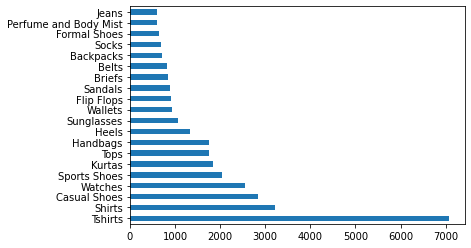

In [15]:
# Top 20 classes
top20_classes = df.articleType.value_counts().head(20)
top20_classes.plot(kind='barh')

In [16]:
print(f'Total items in top-20 classes: {top20_classes.sum()}')
print(f'Total other classes: {len(df) - top20_classes.sum()}')

Total items in top-20 classes: 33142
Total other classes: 11277


In [17]:
def split_data_train_test(data: pd.DataFrame, select_classes: pd.Series):
    # Test set
    test = data[data.year % 2 == 1]
    print(f'Test shape: {test.shape}')
    
    # Train sets
    train_select = data[(data.year % 2 == 0) & data.articleType.isin(select_classes.index)]
    train_other = data[(data.year % 2 == 0) & ~data.articleType.isin(select_classes.index)]
    print(f'Train selected shape: {train_select.shape}')
    print(f'Train other shape:  {train_other.shape}')
    
    return train_select, train_other, test

In [18]:
train_top20, train_other, test = split_data_train_test(df, top20_classes)

Test shape: (20634, 12)
Train selected shape: (17998, 12)
Train other shape:  (5786, 12)


<AxesSubplot:>

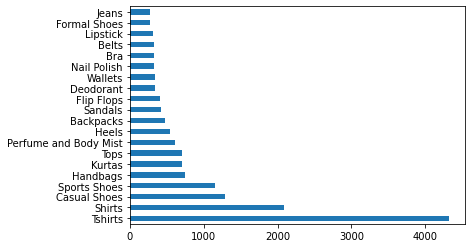

In [19]:
test.articleType.value_counts().head(20).plot(kind='barh')

In [20]:
# Check splitting

In [21]:
# Check which classes are in train set
check_train_top20 = top20_classes.reset_index()
check_train_top20.columns = ['articleType', 'counts']
check_train_top20['top20_is_in'] = check_train_top20.articleType.isin(train_top20.articleType)

In [22]:
print(f'Are all top 20 classes in train: {check_train_top20.top20_is_in.all()}')

Are all top 20 classes in train: False


In [23]:
# Create final dataset indices and save them

In [24]:
def create_index_from_data(data, filename):
    data_final = pd.DataFrame(columns=['image', 'class', 'class_label'])
    data_final['image'] = data.image
    data_final['class'] = data['class']
    data_final['class_label'] = data.articleType
    data_final = data_final.reset_index(drop=True)
    data_final.to_pickle(filename)
    return data_final

In [25]:
create_index_from_data(df, os.path.join(DATA_DIR, 'all_data.p'))
create_index_from_data(test, os.path.join(DATA_DIR, 'test.p'))
create_index_from_data(train_top20, os.path.join(DATA_DIR, 'train_top20.p'))
create_index_from_data(train_other, os.path.join(DATA_DIR, 'train_other.p'))

,image,class,class_label
0,data/myntradataset/images/51832.jpg,23,Bra
1,data/myntradataset/images/48311.jpg,63,Bracelet
2,data/myntradataset/images/59051.jpg,22,Flats
3,data/myntradataset/images/59607.jpg,25,Sarees
4,data/myntradataset/images/54924.jpg,20,Shorts
...,...,...,...
5781,data/myntradataset/images/37267.jpg,24,Dresses
5782,data/myntradataset/images/56250.jpg,46,Night suits
5783,data/myntradataset/images/54163.jpg,44,Necklace and Chains
5784,data/myntradataset/images/15761.jpg,37,Innerwear Vests
